# Pytorch classifier notebook

V1 : only 1 split. First implementation  
All folds V1 : with all folds  
All folds V2 : add activation stats plot  
All folds V2.1 : back to  best MLP found so far, and backport fix of activation layers stats. Add weight decay and scheduler (fit one cycle) code

All folds autoencoder MLP V1  
All folds autoencoder MLP V2 : with weights and biases  
V4 : Xgb resp n-1 predictor and fold predictor as input and Pytorch NN-Resnet as meta model  

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
import torch_optimizer as optim  # Custom optimizers (not officially pytorch) : to use RAdam https://pypi.org/project/torch-optimizer/#radam
import torchvision.transforms as transforms
import torchvision.utils as utils

from torch.utils.tensorboard import SummaryWriter
import io
import PIL.Image

import datetime

import faiss

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42)

DATASET_INPUT_FILE = 'train.csv'

#FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)] + ['cross_41_42_43', 'cross_1_2']
FEATURES_LIST_TOTRAIN = ['feature_'+str(i) for i in range(130)]

# For custom non-overlaped folds generation
TRAIN_PERCENT = 0.70  
TEST_PERCENT = 0.30

# If subsplit of training set : percentage of second training set  
TRAIN1_PERCENT = 0.20  

ACT_N = False  # Add N previous predictions to input of MLP <= Does not work, logic is not right
ACT_N_SIZE = 5

CLUSTERING = False

pd.set_option('display.max_rows', 500)

In [2]:
# Deterministic Behavior
seed = 42
#os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
#random.seed(seed)
# CuDA Determinism
torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [3]:
DO_SWEEP = True
DO_SINGLE_TRAIN = False
#BATCH_SIZE = 50000
#BATCH_SIZE = 4096 # Gave once better results than 50000
#BATCH_SIZE = 2048

#BATCH_SIZE = 300000

#BATCH_SIZE = 4096
#BATCH_SIZE = 8192
#BATCH_SIZE = 32768
BATCH_SIZE = 195837
WEIGHT_DECAY = 0.00012 # Remettre à 1e-5
LEARNING_RATE = 0.0008602
DROPOUT = 0.4019
USE_AUTOENC = 'None'

EARLY_STOPPING = True

NUM_EPOCHS = 1000
#NUM_EPOCHS = 36

MODEL_FILE = f'model_NN_allfolds_V1.pt'

BATCH_SIZE_AE = 40960
NUM_EPOCHS_AE = 1000
LEARNING_RATE_AE = 1e-3
WEIGHT_DECAY_AE = 1e-4
MODEL_FILE_AE = f'model_NN_AE_allfolds_V1.pt'

RETRAIN_MODEl_AE = False

MODEL_COMMENT_AE = f'All folds MLP autoenc, 2 layers 64 32, good model reloaded, batch size {BATCH_SIZE_AE}, lr={LEARNING_RATE_AE}, patience 5, standard scale, weight decay {WEIGHT_DECAY_AE}, dropout 0.5, with cross features, no scheduler, no std scale'
MODEL_COMMENT = f'All folds MLP withOUT autoenc  5 layers 130, 200, 100, 75, 50 (instead of 130, 200 and 100) , good model reloaded, batch size {BATCH_SIZE}, lr={LEARNING_RATE}, patience 20, standard scale, weight decay {WEIGHT_DECAY}, 0.7 dropout, without cross features, no scheduler, no std scale'

In [4]:
'''
sweep_config = {
    'method': 'bayes', #grid, random, bayes
    'metric': {
      'name': 'Best utility',
      'goal': 'maximize'   
    },
    'parameters': {
        'batch_size': {
            'values': [524288, 262144, 131072, 65536, 32768, 16384, 8192, 4096, 2048, 1024, 512]
        },
        'dropout': {
            'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
        },
        'learning_rate': {
            #'values': [1e-2, 1e-3, 1e-4, 3e-4, 1e-5]
            #'values': [1e-2, 1e-3, 1e-4]
            'values': [1e-2, 1e-3]
        },

        'weight_decay': {
            'values': [1e-2, 1e-3, 1e-4, 1e-5]
        },
    
        'use_autoenc': {
            'values': ['encoder-decoder', 'encoder', 'encoder-only', 'None']
            #'values': ['encoder-decoder', 'None']
        },
        
        'activation_function': {
            'values': ['relu', 'leakyrelu']
        },
        
    }
}
'''

sweep_config = {
    'method': 'bayes', #grid, random, bayes
    'metric': {
      'name': 'Best utility',
      'goal': 'maximize'   
    },
    'parameters': {
        'batch_size': {
            'min': 4096,
            'max': 300000,
            
            
            #'min': 300000,
            #'max': 300001,
            'distribution': 'int_uniform',
        },
        'dropout': {
            'min': 0.3,
            'max': 0.5,
            'distribution': 'uniform',
        },
        'learning_rate': {
            'min': 0.0005,
            'max': 0.002,
            'distribution': 'uniform',
        },

        'weight_decay': {
            'min': 0.00001,
            'max': 0.0002,
            'distribution': 'uniform',

        },
    
        'use_autoenc': {
            #'values': ['encoder-only']
            #'values': ['encoder', 'encoder-only']
            #'values': ['encoder-decoder', 'None']
            'values': ['None']
        },
        
        'activation_function': {
            'values': ['leakyrelu']
        },

        
        'hidden_size': {
            'min': 128,
            'max': 512,
            #'max': 256,
            'distribution': 'int_uniform',
        },
        

        
        
    }
}

In [5]:
import wandb

wandb.login()

wandb: Currently logged in as: fboyer (use `wandb login --relogin` to force relogin)


True

In [6]:
def display_memory():
    torch.cuda.empty_cache()
    memory = torch.cuda.memory_allocated('cuda')
    print("{:.3f} GB".format(memory / 1024 ** 3))

In [7]:
def pyStandardScale(tensor, mean, std):
    return((tensor - mean) / std)

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

from matplotlib.colors import ListedColormap
    
# this is code slightly modified from the sklearn docs here:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv_indices_custom(cv_custom, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    
    cmap_cv = plt.cm.coolwarm

    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv_custom):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=plt.cm.Set3)

    ax.scatter(range(len(X)), [ii + 2.5] * len(X),
               c=group, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

In [9]:
# This function accounts for variable instance counts in each split by dividing utility_pi by number of instances (but this has been removed)
# It also does some copy of dataframe to prevent memory overwrite
def utility_function(df_test, df_test_predictions):
    df_test_copy = df_test.copy(deep=True)
    df_test_copy.loc[:, 'utility_pj'] = df_test_copy['weight'] * df_test_copy['resp'] * df_test_predictions
    #df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum() / df_test_copy.groupby('date')['utility_pj'].count()
    df_test_utility_pi = df_test_copy.groupby('date')['utility_pj'].sum()

    nb_unique_dates = df_test_utility_pi.shape[0]

    if (np.sqrt(df_test_utility_pi.pow(2).sum()) == 0):
        t = 0

    else:
        t = (df_test_utility_pi.sum() / np.sqrt(df_test_utility_pi.pow(2).sum())) * (np.sqrt(250 / np.abs(nb_unique_dates)))

    u = min(max(t, 0), 6) * df_test_utility_pi.sum()
    del df_test_copy
    
    return(u)

In [10]:
from bisect import bisect_left

# The aim of this function is to return closest date from an index
# So that split indices correspond to start or end of a new day
# myList contains list of instances that correspond to start of a new da

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return after
    else:
       return before

In [11]:
class SaveOutputActivationStats:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        #self.outputs.append(module_out)
        #print('Save output callback :')
        #print(module)
        #print({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        self.outputs.append({'mean': module_out.mean().item(), 'std': module_out.std().item(),'near_zero': (module_out<=0.05).long().sum().item()/module_out.numel()})
        
    def clear(self):
        self.outputs = []

In [12]:
#fig, ax = plt.subplots(1, 1)
#
#plot_cv_indices(cv, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20);

In [13]:
torch.device

torch.device

In [14]:
torch.cuda.is_available()

True

In [15]:
torch.cuda.current_device()

0

In [16]:
torch.cuda.get_device_name(0)

'GeForce RTX 3090'

# Load data

In [17]:
# Load data
    
df = pd.read_csv(DATASET_INPUT_FILE)
df['resp_positive'] = ((df['resp'])>0)*1  # Target to predict

print('Data loaded')


Data loaded


# Feature engineering

In [18]:
#df['cross_41_42_43'] = df['feature_41'] + df['feature_42'] + df['feature_43']

In [19]:
#df['cross_1_2'] = df['feature_1'] / (df['feature_2'] + 1e-5)

# Non overlap fold generation

In [20]:
date_indexes_list = df.groupby('date')['ts_id'].first().to_list()

In [21]:
base_train_split_size = int((df.shape[0] // 5) * TRAIN_PERCENT)

In [22]:
base_test_split_size = int((df.shape[0] // 5) * TEST_PERCENT)

In [23]:
train_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [24]:
#test_split_start_indexes = [take_closest(date_indexes_list, (base_train_split_size + base_test_split_size)*fold_indice) for fold_indice in range(5)]

In [25]:
train_split_start_indexes

[0, 477711, 958233, 1435933, 1913985]

In [26]:
df.shape[0] - 1

2390490

In [27]:
# We'll have 5 folds of 3 subsets each (2 training sets and 1 test set per fold)
# (1st training set of each fold will be used for 1st model, ie auto encoder)

NB_FOLDS = 5
last_index = df.shape[0] - 1

cv_table = []

for fold_indice in range(NB_FOLDS):
    fold_train_start_index = train_split_start_indexes[fold_indice]
    
    if (fold_indice == NB_FOLDS - 1):    
        nextfold_train_start_index = last_index
        
    else:
        nextfold_train_start_index = train_split_start_indexes[fold_indice + 1]
    
    fold_test_start_index = take_closest(date_indexes_list, int(TRAIN_PERCENT * (nextfold_train_start_index - fold_train_start_index) + fold_train_start_index  ))
    fold_train2_start_index = take_closest(date_indexes_list, int(TRAIN1_PERCENT * (fold_test_start_index - fold_train_start_index) + fold_train_start_index  ))
    
    cv_table.append(fold_train_start_index)
    cv_table.append(fold_train2_start_index)
    cv_table.append(fold_test_start_index)

In [28]:
cv_table.append(last_index)

In [29]:
cv_table

[0,
 66091,
 336609,
 477711,
 546983,
 815783,
 958233,
 1024471,
 1290282,
 1435933,
 1505171,
 1771833,
 1913985,
 1980610,
 2248510,
 2390490]

In [30]:
cv_table

[0,
 66091,
 336609,
 477711,
 546983,
 815783,
 958233,
 1024471,
 1290282,
 1435933,
 1505171,
 1771833,
 1913985,
 1980610,
 2248510,
 2390490]

In [31]:
NB_FOLDS

5

In [32]:
cv_tuples = []

for i in range(0, NB_FOLDS*3, 3):
    cv_tuples.append([df.loc[cv_table[i]:cv_table[i+1]-1, :].index.to_list(), df.loc[cv_table[i+1]:cv_table[i+2]-1, :].index.to_list(),
                      df.loc[cv_table[i+2]:cv_table[i+3]-1, :].index.to_list()])

In [33]:
len(cv_tuples[0][2])

141102

In [34]:
cv_tuples_generator = iter(cv_tuples)

In [35]:
#fig, ax = plt.subplots(1, 1)

#plot_cv_indices_custom(cv_tuples_generator, df.loc[:, FEATURES_LIST_TOTRAIN], (df['resp'] > 0), df['date'], 
#                         ax, 5, lw=20); 

#cv_tuples_generator = iter(cv_tuples)

In [36]:
# Size of training set :
#train_sets_table =  [cv_tuples[i][0] for i in range(5)]
#sum([len(train_set_table) for train_set_table in train_sets_table])

In [37]:
# Our old time series split (with overlap : required 1 neural network trained per split)
# But in this script it's not needed because we're training 1 unique network, with a different fold strategy (non overlaped)
#cv = PurgedGroupTimeSeriesSplit(
#    n_splits=5,
#    max_train_group_size=180,
#    group_gap=20,
#    max_test_group_size=60
#)

In [38]:
#train_index, test_index = next(cv.split(df, (df['resp'] > 0)*1, df['date']))

In [39]:
#(df.loc[train_index, 'resp'] > 0).astype(np.byte)

In [40]:
f_mean = df.loc[:, FEATURES_LIST_TOTRAIN].mean(axis=0)

In [41]:
f_mean.shape

(130,)

In [42]:
df.fillna(f_mean, inplace=True)

In [43]:
#print('Sum of model parameters:')
#[print(p.sum()) for p in model.parameters()]

In [44]:
#writer = SummaryWriter()

#writer.add_text('test', 'test:'  + str(model).replace('\n', '<BR>'))

#writer.flush()
#writer.close()

In [45]:
#str([p.numel() for p in model.parameters()])

In [46]:
folds_list = []

for fold, (train1_index, train2_index, test_index) in enumerate(cv_tuples_generator):
    folds_list.append((train1_index, train2_index, test_index))

In [47]:
folds_list_train1 = [folds_list[i][0] for i in range(5)]
folds_list_train1_flat = [folds_list_train1_item for sublist in folds_list_train1 for folds_list_train1_item in sublist]
folds_list_train1_unique = list(set(folds_list_train1_flat))

folds_list_train2 = [folds_list[i][1] for i in range(5)]
folds_list_train2_flat = [folds_list_train2_item for sublist in folds_list_train2 for folds_list_train2_item in sublist]
folds_list_train2_unique = list(set(folds_list_train2_flat))

In [48]:
len(folds_list_train1_unique)

337464

In [49]:
len(folds_list_train2_unique)

1339691

In [50]:
np.sum([len(folds_list_train1_item) for folds_list_train1_item in folds_list_train1])

337464

In [51]:
np.sum([len(folds_list_train2_item) for folds_list_train2_item in folds_list_train2])

1339691

In [52]:
len(folds_list_train1_flat)

337464

In [53]:
folds_list_test = [folds_list[i][2] for i in range(5)]
folds_list_test_flat = [folds_list_test_item for sublist in folds_list_test for folds_list_test_item in sublist]
folds_list_test_unique = set(folds_list_test_flat)

In [54]:
np.sum([len(folds_list_test_item) for folds_list_test_item in folds_list_test])

713335

In [55]:
len(folds_list_test_flat)

713335

In [56]:
len(folds_list_train1_flat) + len(folds_list_train2_flat) + len(folds_list_test_flat)

2390490

In [57]:
df.loc[folds_list_test[4], FEATURES_LIST_TOTRAIN].to_numpy().shape

(141980, 130)

In [58]:
df.loc[(folds_list_train1_unique + folds_list_train2_unique), FEATURES_LIST_TOTRAIN].to_numpy().mean(axis=0)

array([ 0.00880718,  0.39574469,  0.33059838,  0.00919269,  0.00341737,
       -0.00498373, -0.01455459,  0.05534631,  0.02511896,  0.2646538 ,
        0.16705702,  0.09489698,  0.04450428,  0.15251293,  0.07996651,
        0.22166532,  0.12827658,  0.12181565,  0.10958852,  0.29772963,
        0.26463247,  0.1881408 ,  0.17251055,  0.25474009,  0.23267903,
        0.29794049,  0.2685417 ,  0.13985131,  0.16285107,  0.33060734,
        0.34385913,  0.22684687,  0.25190658,  0.31637359,  0.3359838 ,
        0.35284181,  0.36773315,  0.02650339,  0.0186391 ,  0.04320553,
        0.05298663,  0.45417433,  0.37762691,  0.41617323,  0.43927675,
        0.48651095,  0.49207956,  0.36839975,  0.50144387,  0.54379067,
        0.53074971,  0.45673965,  0.05646874,  0.38900233,  0.37690587,
        0.77549302,  0.92466193,  0.78590429,  0.80847667,  0.89895923,
        0.55335406,  0.55554392,  0.55922873,  0.56139559,  0.44231975,
        0.61884351,  0.61715568,  0.59770334,  0.59814018,  0.37

In [59]:
len(list(set(folds_list_train1_unique + folds_list_train2_unique)))

1677155

In [60]:
torch.mean(torch.tensor(df.loc[(folds_list_train1_unique + folds_list_train2_unique), FEATURES_LIST_TOTRAIN].to_numpy(), device='cpu'), axis=0)

tensor([ 0.0088,  0.3957,  0.3306,  0.0092,  0.0034, -0.0050, -0.0146,  0.0553,
         0.0251,  0.2647,  0.1671,  0.0949,  0.0445,  0.1525,  0.0800,  0.2217,
         0.1283,  0.1218,  0.1096,  0.2977,  0.2646,  0.1881,  0.1725,  0.2547,
         0.2327,  0.2979,  0.2685,  0.1399,  0.1629,  0.3306,  0.3439,  0.2268,
         0.2519,  0.3164,  0.3360,  0.3528,  0.3677,  0.0265,  0.0186,  0.0432,
         0.0530,  0.4542,  0.3776,  0.4162,  0.4393,  0.4865,  0.4921,  0.3684,
         0.5014,  0.5438,  0.5307,  0.4567,  0.0565,  0.3890,  0.3769,  0.7755,
         0.9247,  0.7859,  0.8085,  0.8990,  0.5534,  0.5555,  0.5592,  0.5614,
         0.4423,  0.6188,  0.6172,  0.5977,  0.5981,  0.3774,  0.2389,  0.3080,
         0.0041, -0.0322, -0.0016, -0.0199, -0.0316, -0.0932, -0.0081, -0.0358,
        -0.0025, -0.0149, -0.0350, -0.1015,  0.3934,  0.5416,  0.3924,  0.4281,
         0.4976,  0.3994,  0.4332,  0.5235,  0.4224,  0.4221,  0.4348,  0.4547,
         0.3984,  0.5422,  0.3973,  0.42

In [61]:
torch.tensor(f_mean)

tensor([ 9.8386e-03,  3.8558e-01,  3.5769e-01,  8.9192e-03,  4.1501e-03,
        -3.7146e-03, -1.2589e-02,  5.1777e-02,  2.6828e-02,  2.4881e-01,
         1.8235e-01,  8.9122e-02,  4.9486e-02,  1.4311e-01,  8.9027e-02,
         2.1168e-01,  1.4630e-01,  1.2122e-01,  1.1358e-01,  2.9381e-01,
         2.6877e-01,  1.8691e-01,  1.7698e-01,  2.5244e-01,  2.3856e-01,
         2.9407e-01,  2.7318e-01,  1.3548e-01,  1.6088e-01,  3.2189e-01,
         3.4253e-01,  2.2056e-01,  2.5013e-01,  3.0822e-01,  3.3535e-01,
         3.4145e-01,  3.6583e-01,  2.9320e-02,  2.2892e-02,  4.0022e-02,
         5.0750e-02,  4.4505e-01,  3.6018e-01,  3.4603e-01,  4.1153e-01,
         4.3803e-01,  4.7612e-01,  3.4787e-01,  4.9963e-01,  5.6400e-01,
         5.1226e-01,  4.5739e-01,  4.5744e-02,  3.6270e-01,  3.5887e-01,
         6.5260e-01,  8.0495e-01,  6.6135e-01,  6.7981e-01,  7.6259e-01,
         5.5640e-01,  5.5817e-01,  5.4554e-01,  5.4678e-01,  4.3506e-01,
         6.0757e-01,  6.0850e-01,  5.9519e-01,  5.9

# Training KMeans clusterer

In [62]:
class FaissKMeans:
    def __init__(self, n_clusters=8, n_init=10, max_iter=300):
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]



In [63]:
df_forclustering = df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN].astype({'feature_0': np.float32})

In [64]:
df_forclustering = np.copy(df_forclustering[FEATURES_LIST_TOTRAIN].to_numpy(), order='C')

In [65]:
NB_CLUSTERS = 5

clusterer = FaissKMeans(n_clusters=NB_CLUSTERS, n_init=10, max_iter=3000)
clusterer.fit(df_forclustering)

In [66]:
df_full = df.loc[:, FEATURES_LIST_TOTRAIN].astype({'feature_0': np.float32})
df_full = np.copy(df_full[FEATURES_LIST_TOTRAIN].to_numpy(), order='C')

In [67]:
y_clusters = clusterer.predict(df_full)

In [68]:
df['cluster'] = y_clusters + 1  # +1 to avoid cluster indice 0 (less practical for gradients)

In [69]:
if (CLUSTERING == True):
    FEATURES_LIST_TOTRAIN = FEATURES_LIST_TOTRAIN + ['cluster']

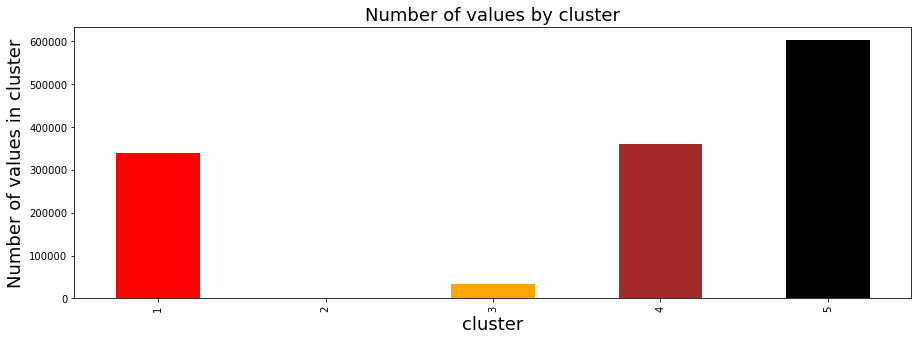

In [70]:
colors = ['red', 'blue', 'orange', 'brown', 'black']

fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Number of values in cluster', fontsize=18)
ax.set_title('Number of values by cluster', fontsize=18)

df.loc[folds_list_train2_unique, :].groupby(by='cluster')['resp'].count().plot.bar(figsize=(15,5), ax=ax, color=colors);

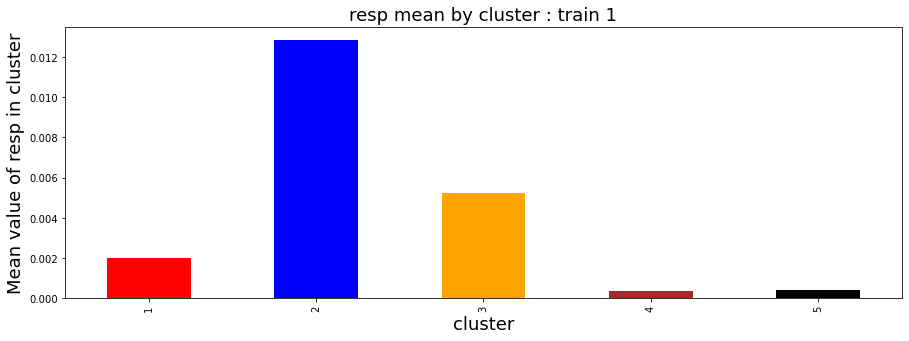

In [71]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Mean value of resp in cluster', fontsize=18)
ax.set_title('resp mean by cluster : train 1', fontsize=18)

df.loc[folds_list_train1_unique, :].groupby(by='cluster')['resp'].mean().plot.bar(figsize=(15,5), ax=ax, color=colors);

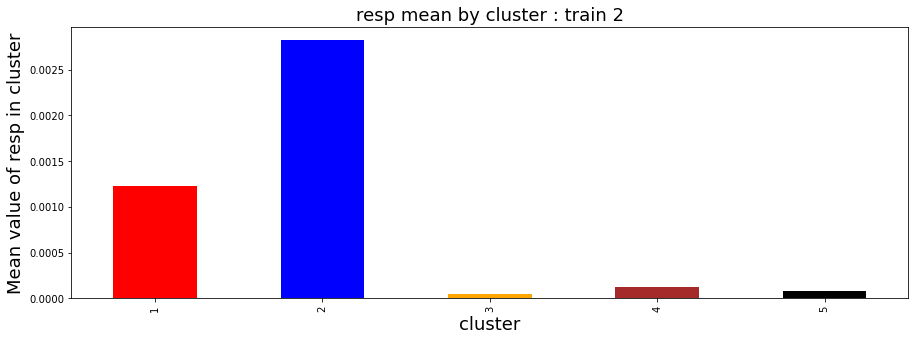

In [72]:
fig, ax = plt.subplots(figsize=(15, 5))
#ax = axes.ravel()
#fig.tight_layout(pad=10.0)

ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Mean value of resp in cluster', fontsize=18)
ax.set_title('resp mean by cluster : train 2', fontsize=18)

df.loc[folds_list_train2_unique, :].groupby(by='cluster')['resp'].mean().plot.bar(figsize=(15,5), ax=ax, color=colors);

# Training auto encoder

In [65]:
torch.manual_seed(seed)  

ENCODER_SIZE = 32
    
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        
        self.encoder = nn.Sequential(
            #nn.Dropout(0.5),  # Noise layer
            nn.Linear(len(FEATURES_LIST_TOTRAIN), 64),
            nn.ReLU(),
            nn.Linear(64, ENCODER_SIZE),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(             
            nn.Linear(ENCODER_SIZE, 64),
            nn.ReLU(),
            nn.Linear(64, len(FEATURES_LIST_TOTRAIN)),
        )
        
    def forward(self,x):
        if self.training:
            x = x + 0.1 * torch.randn(x.shape[0], x.shape[1]).double(). to('cuda')  # 0.1 = noise variance
            
        x = self.encoder(x)
        x = self.decoder(x)
        return x        

model = AutoEncoder().double().to('cuda')
    
#print('Number of model parameters :')
#numel_list = [p.numel() for p in model.parameters()]
#sum(numel_list), numel_list
    
if (RETRAIN_MODEl_AE == False):
    model_AE = model
    model_AE.load_state_dict(torch.load(MODEL_FILE_AE,map_location=torch.device('cuda')))
    print('Model AE loaded')

else:    
    print('Training started')
    patience=5

    utility_scores = [None] * 5
    accuracy_scores = [None] * 5

    today = datetime.datetime.now()
    now_str = today.strftime("%b%d_%H-%M-%S")
    tensorboard_dir_AE = 'runs_AE/' + now_str
    writer = SummaryWriter(log_dir=tensorboard_dir_AE)

    ts_train = torch.tensor(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    #ts_train_y = torch.tensor((df.loc[folds_list_train_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize data
    ts_train_mean = torch.mean(ts_train, axis=0)
    ts_train_std = torch.std(ts_train, axis=0)
    #ts_train_mean = torch.tensor(f_mean)
    # If you want to use Standard scale : calculate mean from f_mean and std scale from whole dataset
    #ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

    train_dataset = torch.utils.data.TensorDataset(ts_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_AE, shuffle=True)

    ts_test = [None] * 5
    #ts_test_y = [None] * 5    
    test_dataset = [None] * 5
    test_loader = [None] * 5

    for fold_indice in range(5):
        ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
        #ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

        # Normalize
        #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)

        test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice])
        test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=BATCH_SIZE_AE)

    loss_fn = nn.MSELoss().to('cuda')
    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_AE, weight_decay=WEIGHT_DECAY_AE) 

    scheduler = None
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
    #                                                         max_lr=1e-4, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

    #model.eval()
    #start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
    #print('Start Validation Utility: {:.4f}'.format(start_utility_score))

    Val_Loss = 0
    N_Samples = 0

    the_last_loss = 10000
    the_last_utility_score = 0
    the_last_accuracy = 0
    trigger_times=0
    early_stopping_met = False

    for epoch in range(NUM_EPOCHS_AE): 
        running_loss = 0.0        

        ### Call back to save activation stats (mean, std dev and near 0 values after activation functions)
        # Setting hook for activation layers stats

        hook_handles = []
        save_output_activation_stats = []

        for layer in model.modules():
            if ('activation' in str(type(layer))):
                save_output_activation_stats_1layer = SaveOutputActivationStats()
                handle = layer.register_forward_hook(save_output_activation_stats_1layer)
                save_output_activation_stats.append(save_output_activation_stats_1layer)
                hook_handles.append(handle)    

        model.train()

        for batch in train_loader:
            #inputs, labels = batch[0], batch[1]
            inputs = batch[0].to('cuda')
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = loss_fn(outputs, inputs.double())
                loss.backward()
                optimizer.step()

                if scheduler:
                    scheduler.step()

        # update local train loss
            running_loss += loss.item() * inputs.size(0)

        # update global train loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

        writer.add_scalar(f"Global train/loss", epoch_loss, epoch)

        # Write activation stats graphs
        for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
            df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

            fig, ax = plt.subplots(1, 3, figsize=(25, 4))

            ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
            ax[0].set_xlabel('Batch instances')
            ax[0].set_ylabel('Mean')
            ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

            ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
            ax[1].set_xlabel('Batch instances')
            ax[1].set_ylabel('Standard deviation')
            ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

            ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
            ax[2].set_xlabel('Batch instances')
            ax[2].set_ylabel('Percentage')
            ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

            plot_buf = io.BytesIO()
            plt.savefig(plot_buf, format='jpeg')
            plt.close()

            plot_buf.seek(0)
            image = PIL.Image.open(plot_buf)
            image = transforms.ToTensor()(image)
            writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)

        # Validation 
        model.eval()

        vrunning_loss = [None] * 5
        num_samples = [None] * 5
        vepoch_loss_folds = [None] * 5
        vepoch_accuracy_folds = [None] * 5
        vepoch_utility_score_folds = [None] * 5

        for fold_indice in range(5):    
            vrunning_loss[fold_indice] = 0.0
            num_samples[fold_indice] = 0

            for batch in test_loader[fold_indice]:
                inputs = batch[0].to('cuda')

                optimizer.zero_grad()
                with torch.no_grad():
                    outputs = model(inputs)
                    loss = loss_fn(outputs, inputs.double())

                vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
                num_samples[fold_indice] += inputs.size(0)

                vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

            print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))        

        # update epoch loss
        vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
        print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))

        #print(f'Sum of model parameters ({epoch}):')
        #[print(p.sum()) for p in model.parameters()]

        writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)

        for fold_indice in range(5):
            writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)        

        writer.flush()

        # Check if Early Stopping

        if (vepoch_loss > the_last_loss):
            if (EARLY_STOPPING == True):
                trigger_times += 1

                print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')

                if trigger_times >= patience:
                    print('Meet Early stopping!')
                    early_stopping_met = True
                    ##torch.save(model.state_dict(), f'model_{fold}.pt')
                    break
        else:
            trigger_times = 0
            the_last_loss = vepoch_loss

            the_best_epoch = epoch

            # Save model for the best version so far
            print(f'Saving model corresponding to last_loss == {the_last_loss}')
            torch.save(model.state_dict(), MODEL_FILE_AE)

        print('\n')

    if (early_stopping_met == False):
        print("Didn't meet early stopping : saving final model")
        # Save model if don't meet early stopping
        torch.save(model.state_dict(), MODEL_FILE_AE)

    writer.add_text(f"Global valid/Loss", f"Best loss: {the_last_loss}", the_best_epoch)

    scores_results = {'Loss': the_last_loss, 'Loss folds': vepoch_loss_folds, 'Loss_std': np.std(vepoch_loss_folds)}

    writer.add_text('Final score', str(scores_results))
    writer.add_text('Batch size', str(BATCH_SIZE_AE))
    writer.add_text('Patience', str(patience))
    writer.add_text('Number of epochs', str(NUM_EPOCHS_AE))
    writer.add_text('Best epoch', str(the_best_epoch))
    writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
    writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
    writer.add_text('Comment', MODEL_COMMENT_AE)

    writer.close()

    print('Training summary:')
    print(scores_results)

    model_AE = model
    model_AE.eval()
    print('Training ended')

Model AE loaded


With noise 0.01 and clustering :  
{'Loss': 0.3849842190821132, 'Loss folds': [0.4477343427193263, 0.36315438263176464, 0.3901575283001523, 0.4046033569269988, 0.31993053528058724], 'Loss_std': 0.0425621624935266}  

With noise 0.1 without clustering :
{'Loss': 0.4013562969953418, 'Loss folds': [0.4683083206738427, 0.38134665501868015, 0.4085802369265447, 0.4217434697302297, 0.3315976695350142], 'Loss_std': 0.04519391402025046}

In [66]:
df[FEATURES_LIST_TOTRAIN].mean().mean()

0.3105054402961592

In [67]:
1.08 / df[FEATURES_LIST_TOTRAIN].mean().mean()

3.4781999277368514

In [68]:
#ts_train.mean(axis=0)

In [69]:
#loss_fn(ts_train[0:5, :], model_AE(ts_train[0:5, :]))

In [70]:
#model_AE(ts_train[0:5, :])[0, 5]

In [71]:
#ts_train[0, 5]

In [72]:
#loss_fn(ts_train[50, 5], model_AE(ts_train[:, :])[50, 5])

# Train model that predicts resp n-1

In [84]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [74]:
class XGBClassifier_wrapper(BaseEstimator, ClassifierMixin):  
    ''' Params passed as dictionnary to __init__, for example :
        params_space = {
       'features': FEATURES_LIST_TOTRAIN, 
        'random_state': 42,
        'max_depth': 12,
        'n_estimators': 500,
        'learning_rate': 0.01,
        'subsample': 0.9,
        'colsample_bytree': 0.3,
        'tree_method': 'gpu_hist'
        }
    '''
    def __init__(self, params):
        self.fitted = False
        
        self.features = list(params['features'])
        self.random_state = params['random_state']
        self.max_depth = params['max_depth']
        self.n_estimators = params['n_estimators']
        self.learning_rate = params['learning_rate']
        self.subsample = params['subsample']
        self.colsample_bytree = params['colsample_bytree']
        self.gamma = params['gamma']
        self.tree_method = params['tree_method']  
        
        #print('Features assigned :')
        #print(self.features)

        self.model_internal = XGBClassifier(
            random_state= self.random_state,
            max_depth= self.max_depth,
            n_estimators= self.n_estimators,
            learning_rate= self.learning_rate,
            subsample= self.subsample,
            colsample_bytree= self.colsample_bytree,
            tree_method= self.tree_method,
            gamma = self.gamma,
            #objective= 'binary:logistic',
            #disable_default_eval_metric=True,
            )

    def fit(self, X, y=None):
        print('Model used for fitting:')
        print(self.model_internal)
        self.model_internal.fit(X[self.features], y)
        
        self.fitted = True
        return self

    def predict(self, X, y=None):
        if (self.fitted == True):
            print('predict called')
            return(self.model_internal.predict(X[self.features]))
        
        else:
            print('You must fit model first')
            return(None)

    def predict_proba(self, X, y=None):
        if (self.fitted == True):
            print('predict proba called')
            return(self.model_internal.predict_proba(X[self.features]))
        
        else:
            print('You must fit model first')
            return(None)
        

    #def set_params(self, **parameters):
    #    for parameter, value in parameters.items():
    #        setattr(self, parameter, value)

        
    def score(self, X, y=None):        
        print('Type of X:')
        print(type(X))
        
        print('Shape of X:')
        print(X.shape)
        
        print('Type of y:')
        print(type(y))
        
        print('model fitted ?')
        print(self.fitted) # Usually returns yes at this point when called by cross_val_score
        
        if y is None:
            print('y is None')
            y_preds = pd.Series(self.model_internal.predict(X.reset_index(drop=True)[self.features]))
            
        else: # cross_val_score goes there
            print('y is not None')
            y_preds = pd.Series(y)
        
        return(utility_function(X.reset_index(drop=True), y_preds)) 
    
    def accuracy_score(self, X, y=None):
        if y is None:
            print('y is None in accuracy_score method : pass predictions as y to avoid launching predict')
            y_preds = pd.Series(self.model_internal.predict(X.reset_index(drop=True)[self.features]))
            
        else: # cross_val_score goes there
            #print('y is not None')
            y_preds = pd.Series(y)
            
        return(accuracy_score(X['resp_positive'], y_preds))

In [75]:
# Calculate label of current step
y_train1_resp_positive = (df.loc[folds_list_train1_unique, 'resp'] > 0).astype(np.byte)

# Shift values of resp to get resp of step n-1
y_train1_resp_n1_positive = y_train1_resp_positive.shift(1, fill_value=0)


model_n1 = XGBClassifier(
    random_state= 42,
    max_depth= 12,
    n_estimators= 500,
    learning_rate= 0.01,
    subsample= 0.9,
    colsample_bytree= 0.2,
    tree_method= 'gpu_hist',
    gamma = None,
    )

model_n1.fit(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN], y_train1_resp_n1_positive, verbose=True)

/opt/anaconda3/envs/janestreet/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:59:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=24, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

# Train model that predicts original fold

## Generate labels

In [76]:
fold_indexes = []

for fold_indice in range(NB_FOLDS):
    fold_indexes.append([item for sublist in folds_list[fold_indice] for item in sublist])
    
for fold_number, fold_indexes_1fold in enumerate(fold_indexes):
    df.loc[fold_indexes_1fold, 'fold_number'] = str(int(fold_number))
    
df.loc[df.shape[0] - 1, 'fold_number'] = str(int(NB_FOLDS - 1))



In [77]:
df['fold_number'].value_counts()

1    480522
3    478052
0    477711
2    477700
4    476506
Name: fold_number, dtype: int64

In [78]:
df.shape

(2390491, 140)

## Fold predictor

In [81]:
model_xgb = XGBClassifier(
    random_state= 42,
    max_depth= 10,
    n_estimators= 500,
    learning_rate= 0.02,
    subsample= 0.5,
    colsample_bytree= 0.6,
    tree_method= 'gpu_hist',
    gamma = None,
    #objective= 'binary:logistic',
    #disable_default_eval_metric=True,
    )

#model_xgb.fit(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN], df.loc[folds_list_train1_unique, ['fold_'+str(i) for i in range(NB_FOLDS)]])
model_xgb.fit(df.loc[folds_list_train1_unique, FEATURES_LIST_TOTRAIN], df.loc[folds_list_train1_unique, 'fold_number'])

[11:03:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=24, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [82]:
[print(pd.Series(model_xgb.predict(df.loc[folds_list_test[i], FEATURES_LIST_TOTRAIN])).value_counts()) for i in range(5)]

0    38357
1    32039
3    25586
2    23961
4    21159
dtype: int64
2    35328
3    34457
4    28933
1    27646
0    16086
dtype: int64
4    43336
3    41516
2    29827
1    15522
0    15450
dtype: int64
4    54848
3    42308
2    20733
1    12215
0    12048
dtype: int64
4    56691
3    38288
2    19587
0    13913
1    13501
dtype: int64


[None, None, None, None, None]

In [85]:
scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

for fold_indice in range(NB_FOLDS): 
    test_predictions = model_xgb.predict(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN])

    accuracy_scores.append(accuracy_score(df.loc[folds_list_test[fold_indice], 'fold_number'], test_predictions))  
    precision_scores.append(precision_score(df.loc[folds_list_test[fold_indice], 'fold_number'], test_predictions, average='micro'))  
    recall_scores.append(recall_score(df.loc[folds_list_test[fold_indice], 'fold_number'], test_predictions, average='micro'))  

    df_featimportance = pd.DataFrame(model_xgb.feature_importances_, index=df[FEATURES_LIST_TOTRAIN].columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
    df_featimportance_cumulated = pd.concat([df_featimportance, pd.DataFrame({'% feat importance cumulé' : (df_featimportance['Importance'] / df_featimportance['Importance'].sum()).cumsum()})], axis=1)
    #print(f'Feature importances for split {fold_indice}:')
    #print(df_featimportance_cumulated)

print({'accuracy_scores': accuracy_scores})
print({'precision_scores': precision_scores})
print({'recall_scores': recall_scores})

{'accuracy_scores': [0.27183881163980667, 0.19407511407511407, 0.2047840385579227, 0.2976250773819573, 0.39928863220171856]}
{'precision_scores': [0.27183881163980667, 0.19407511407511407, 0.2047840385579227, 0.2976250773819573, 0.39928863220171856]}
{'recall_scores': [0.27183881163980667, 0.19407511407511407, 0.2047840385579227, 0.2976250773819573, 0.39928863220171856]}


In [97]:
preds_n1 = model_n1.predict_proba(df.loc[:, FEATURES_LIST_TOTRAIN])

In [98]:
preds_fold = model_xgb.predict_proba(df.loc[:, FEATURES_LIST_TOTRAIN])

In [103]:
df['respn1_predict'] = preds_n1[:, 1]

In [105]:
df['fold_predict'] = preds_fold[:, 1]

In [106]:
FEATURES_LIST_TOTRAIN = FEATURES_LIST_TOTRAIN + ['respn1_predict', 'fold_predict']

# Training main model

In [108]:
if (DO_SWEEP == True):
    sweep_id = wandb.sweep(sweep_config, entity='fboyer', project="janestreet-mlp")

Create sweep with ID: 11zvcrka
Sweep URL: https://wandb.ai/fboyer/janestreet-mlp/sweeps/11zvcrka


In [109]:
def train():
    config_MLP = dict(
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        weight_decay = WEIGHT_DECAY,
        dropout = DROPOUT,
        use_autoenc = USE_AUTOENC,
        activation_function = 'leakyrelu',
        hidden_size = 256,
        )

    if (DO_SWEEP == True):
        #run = wandb.init()
        #config_MLP = run.config
        wandb.init(config=config_MLP) # this config_MLP is ignored when sweep
        config_MLP = wandb.config

    else:
        wandb.init(project='janestreet-mlp', config=config_MLP)
        config_MLP = wandb.config

    print('Training started')
    patience=20

    print('Run config :')
    print("config:", dict(config_MLP))

    utility_scores = [None] * 5
    accuracy_scores = [None] * 5

    writer = SummaryWriter()

    ts_train = torch.tensor(df.loc[folds_list_train2_unique, FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
    ts_train_y = torch.tensor((df.loc[folds_list_train2_unique, 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

    # Normalize data
    ts_train_mean = torch.mean(ts_train, axis=0)
    ts_train_std = torch.std(ts_train, axis=0)
    #ts_train = pyStandardScale(ts_train, ts_train_mean, ts_train_std)

    train_dataset = torch.utils.data.TensorDataset(ts_train, ts_train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config_MLP.batch_size, shuffle=True) # pin_memory : VOIR RESULTAT

    ts_test = [None] * 5
    ts_test_y = [None] * 5    
    test_dataset = [None] * 5
    test_loader = [None] * 5

    for fold_indice in range(5):
        ts_test[fold_indice] = torch.tensor(df.loc[folds_list_test[fold_indice], FEATURES_LIST_TOTRAIN].to_numpy(), device='cuda')
        ts_test_y[fold_indice] = torch.tensor((df.loc[folds_list_test[fold_indice], 'resp'] > 0).astype(np.byte).to_numpy(), device='cuda')

        # Normalize
        #ts_test[fold_indice] = pyStandardScale(ts_test[fold_indice], ts_train_mean, ts_train_std)

        test_dataset[fold_indice] = torch.utils.data.TensorDataset(ts_test[fold_indice], ts_test_y[fold_indice])
        test_loader[fold_indice] = torch.utils.data.DataLoader(test_dataset[fold_indice], batch_size=config_MLP.batch_size)

    torch.manual_seed(seed)

    class MLP(nn.Module):
        def __init__(self, AEncoder):
        #def __init__(self):
            super(MLP,self).__init__()

            #self.act_n = torch.zeros((config_MLP.batch_size, ACT_N_SIZE))
            if (ACT_N == True):
                self.act_n = torch.zeros(ACT_N_SIZE, device='cuda').unsqueeze(0)
                act_n_size = ACT_N_SIZE

            else:
                act_n_size = 0
                
            self.AEncoder = AEncoder

            if (config_MLP.use_autoenc == 'encoder-decoder'):
                #self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + self.AEncoder.decoder[0].in_features, 200)
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) * 2 + act_n_size, 200) # <= % near 0 élevé

            elif (config_MLP.use_autoenc == 'encoder'):
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + ENCODER_SIZE + act_n_size, 200) # <= % near 0 élevé

            elif (config_MLP.use_autoenc == 'encoder-only'):
                self.layer1 = nn.Linear(ENCODER_SIZE + act_n_size, 200) # <= % near 0 élevé
                
            else:
                self.layer1 = nn.Linear(len(FEATURES_LIST_TOTRAIN) + act_n_size, 200) # <= % near 0 élevé

            if (config_MLP.activation_function == 'relu'):
                self.act1 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act1 = nn.LeakyReLU()
                
            self.dropout1 = nn.Dropout(config_MLP.dropout)

            self.layer2 = nn.Linear(200, 100)

            if (config_MLP.activation_function == 'relu'):
                self.act2 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act2 = nn.LeakyReLU()

            self.dropout2 = nn.Dropout(config_MLP.dropout)

            self.layer3 = nn.Linear(100, 75)

            if (config_MLP.activation_function == 'relu'):
                self.act3 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act3 = nn.LeakyReLU()

            self.dropout3 = nn.Dropout(config_MLP.dropout)
            
            self.layer4 = nn.Linear(75, 50)

            if (config_MLP.activation_function == 'relu'):
                self.act4 = nn.ReLU()
                
            elif (config_MLP.activation_function == 'leakyrelu'):
                self.act4 = nn.LeakyReLU()

            self.dropout4 = nn.Dropout(config_MLP.dropout)

            self.layer5 = nn.Linear(50, 1)
            self.act5 = nn.Sigmoid()

        def encoder(self, x):
            self.AEncoder.eval()

            encoded = self.AEncoder.encoder(x)

            return encoded

        def encoder_decoder(self, x):
            self.AEncoder.eval()

            encoded_decoded = self.AEncoder(x)

            return encoded_decoded

        def forward(self,x):
            #x_encoded = self.encoder(x)

            #x = torch.cat((x, x_encoded), dim=1)
            if (config_MLP.use_autoenc == 'encoder-decoder'):
                x_decoded = self.encoder_decoder(x)
                x = torch.cat((x, x_decoded), dim=1)

            elif (config_MLP.use_autoenc == 'encoder'):
                x_decoded = self.encoder(x)
                x = torch.cat((x, x_decoded), dim=1)

            elif (config_MLP.use_autoenc == 'encoder-only'):
                x_decoded = self.encoder(x)
                x = x_decoded
                
            else:
                pass

            if (ACT_N == True):
                x = torch.cat((x, self.act_n.expand(x.shape[0], ACT_N_SIZE)), dim=1)    

            x = self.dropout1(self.act1(self.layer1(x)))
            x = self.dropout2(self.act2(self.layer2(x)))
            
            x = self.dropout3(self.act3(self.layer3(x)))
            x = self.dropout4(self.act4(self.layer4(x)))

            x = self.act5(self.layer5(x))            

            # Remove oldest previously saved output (located at the end of tensor => index -1 for not selecting it) of NN and replace by new one (which is x, that we assign at start of tensor)
            # expand() because self.act_n when first assigned has only 1 line, but here it expands to number of lines in x (batch size)
            if (ACT_N == True):
                self.act_n = torch.cat((x, self.act_n[:, :-1].expand(x.shape[0], ACT_N_SIZE-1)), dim=1)


            #print('self.act_n:')
            #print(self.act_n)

            return x        

    class Model_Resnet(nn.Module):
        def __init__(self):
            super(Model_Resnet, self).__init__()
            self.batch_norm0 = nn.BatchNorm1d(len(FEATURES_LIST_TOTRAIN))
            self.dropout0 = nn.Dropout(0.2)

            dropout_rate = config_MLP.dropout
            hidden_size = config_MLP.hidden_size
            self.dense1 = nn.Linear(len(FEATURES_LIST_TOTRAIN), hidden_size)
            self.batch_norm1 = nn.BatchNorm1d(hidden_size)
            self.dropout1 = nn.Dropout(dropout_rate)
            
            self.cat1 = lambda a,b : torch.cat([a, b], 1)

            self.dense2 = nn.Linear(hidden_size+len(FEATURES_LIST_TOTRAIN), hidden_size)
            self.batch_norm2 = nn.BatchNorm1d(hidden_size)
            self.dropout2 = nn.Dropout(dropout_rate)

            self.cat2 = lambda a,b : torch.cat([a, b], 1)
            
            self.dense3 = nn.Linear(hidden_size+hidden_size, hidden_size)
            self.batch_norm3 = nn.BatchNorm1d(hidden_size)
            self.dropout3 = nn.Dropout(dropout_rate)

            self.cat3 = lambda a,b : torch.cat([a, b], 1)            
            
            self.dense4 = nn.Linear(hidden_size+hidden_size, hidden_size)
            self.batch_norm4 = nn.BatchNorm1d(hidden_size)
            self.dropout4 = nn.Dropout(dropout_rate)

            self.cat4 = lambda a,b : torch.cat([a, b], 1)            
            
            self.dense5 = nn.Linear(hidden_size+hidden_size, 1)
            self.act5 = nn.Sigmoid()

            self.LeakyReLU1 = nn.LeakyReLU(negative_slope=0.01)
            self.LeakyReLU2 = nn.LeakyReLU(negative_slope=0.01)
            self.LeakyReLU3 = nn.LeakyReLU(negative_slope=0.01)
            self.LeakyReLU4 = nn.LeakyReLU(negative_slope=0.01)

        def forward(self, x):
            x = self.dropout0(self.batch_norm0(x))

            x1 = self.dropout1(self.LeakyReLU1(self.batch_norm1(self.dense1(x))))
            x = self.cat1(x, x1)

            x2 = self.dropout2(self.LeakyReLU2(self.batch_norm2(self.dense2(x))))
            x = self.cat2(x1, x2)

            x3 = self.dropout3(self.LeakyReLU3(self.batch_norm3(self.dense3(x))))
            x = self.cat3(x2, x3)

            x4 = self.dropout4(self.LeakyReLU4(self.batch_norm4(self.dense4(x))))

            x = self.cat4(x3, x4)

            x = self.act5(self.dense5(x))

            return x        
    
    #model = MLP(model_AE).double().to('cuda')
    
    #for param in model.AEncoder.parameters():
        #param.requires_grad = False

    model = Model_Resnet().double().to('cuda')
        
    '''
    model = nn.Sequential(
            #nn.Dropout(0.2),
            nn.Linear(len(FEATURES_LIST_TOTRAIN), 200),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(200, 150),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(150, 100),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(100, 80),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(80, 60),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(60, 50),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(50, 40),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(40, 30),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(30, 20),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(config_MLP['dropout']),

            nn.Linear(20, 10),
            #nn.BatchNorm1d(130),
            nn.LeakyReLU(),
            nn.Dropout(0.45),

            nn.Linear(10, 1),
            nn.Sigmoid(),
        ).double().to('cuda')
    '''

    #print('Number of model parameters :')
    #numel_list = [p.numel() for p in model.parameters()]
    #sum(numel_list), numel_list

    loss_fn = nn.BCELoss().to('cuda')

    #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    #optimizer = torch.optim.Adam(model.parameters(), lr=config_MLP.learning_rate, weight_decay=config_MLP.weight_decay) 
    
    # According to this, Adam can sometimes update parameters even if they are frozen with requires_grad : 
    # https://discuss.pytorch.org/t/why-is-it-when-i-call-require-grad-false-on-all-my-params-my-weights-in-the-network-would-still-update/22126/14
    # So we exclude frozen parameters when calling the optimizer, with a filter
    optimizer = optim.RAdam(filter(lambda p: p.requires_grad, model.parameters()), lr=config_MLP.learning_rate, weight_decay=config_MLP.weight_decay) 

    scheduler = None
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
    #                                                         max_lr=1e-4, epochs=config_MLP.epochs, steps_per_epoch=len(train_loader))

    #if (DO_SWEEP == False):
    wandb.watch(model, loss_fn, log="all", log_freq=1)

    model.eval()
    #start_accuracy = accuracy_score(ts_test_y.cpu().numpy(), (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #start_utility_score = utility_function(df.loc[test_index], (model(ts_test).squeeze() > 0.5).cpu().numpy())
    #print('Start Validation Accuracy: {:.4f}'.format(start_accuracy))
    #print('Start Validation Utility: {:.4f}'.format(start_utility_score))


    Val_Loss = 0
    N_Samples = 0

    the_last_loss = 100
    the_last_utility_score = 0
    the_last_accuracy = 0
    trigger_times=0
    early_stopping_met = False

    for epoch in range(config_MLP.epochs): 
        running_loss = 0.0        

        ### Call back to save activation stats (mean, std dev and near 0 values after activation functions)
        # Setting hook for activation layers stats

        hook_handles = []
        save_output_activation_stats = []

        for layer in model.modules():
            if ('activation' in str(type(layer))):
                save_output_activation_stats_1layer = SaveOutputActivationStats()
                handle = layer.register_forward_hook(save_output_activation_stats_1layer)
                save_output_activation_stats.append(save_output_activation_stats_1layer)
                hook_handles.append(handle)    

        model.train()

        for batch in train_loader:
            #inputs, labels = batch[0], batch[1]
            inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

            optimizer.zero_grad()

            # with torch.set_grad_enabled(True):  # A enlever ? (réactive les gradients de l'auto encoder ?)
            # Ce with couvrait jusqu'à scheduler.step()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.unsqueeze(-1).double())

            #loss.backward(retain_graph=True)
            loss.backward()
            optimizer.step()


            if scheduler:
                scheduler.step()

        # update local train loss
            running_loss += loss.item() * inputs.size(0)

        # update global train loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print('Epoch({}) - Training Loss: {:.4f}'.format(epoch, epoch_loss))

        writer.add_scalar(f"Global train/loss", epoch_loss, epoch)
        wandb.log({'Global train/loss' : epoch_loss}, step=epoch)

        # Write activation stats graphs
        for layer_number,save_output_activation_stats_layer in enumerate(save_output_activation_stats):
            df_stats_layer = pd.DataFrame(save_output_activation_stats_layer.outputs)

            if ((df_stats_layer.shape[0] == 0) and (df_stats_layer.shape[1] == 0)):
                print(f'Activation stats: No data returned for stats at layer {layer_number}')

            else:
                fig, ax = plt.subplots(1, 3, figsize=(25, 4))

                ax[0].set_title(f'Layer {layer_number} : Mean activation value', fontsize=16)
                ax[0].set_xlabel('Batch instances')
                ax[0].set_ylabel('Mean')
                ax[0].plot(range(df_stats_layer.shape[0]), df_stats_layer['mean'])

                ax[1].set_title(f'Layer {layer_number} : Std deviation activation value', fontsize=16)
                ax[1].set_xlabel('Batch instances')
                ax[1].set_ylabel('Standard deviation')
                ax[1].plot(range(df_stats_layer.shape[0]), df_stats_layer['std'])

                ax[2].set_title(f'Layer {layer_number} : Percentage of activation values near zero', fontsize=16)
                ax[2].set_xlabel('Batch instances')
                ax[2].set_ylabel('Percentage')
                ax[2].plot(range(df_stats_layer.shape[0]), df_stats_layer['near_zero']);

                plot_buf = io.BytesIO()
                plt.savefig(plot_buf, format='jpeg')
                plt.close()

                plot_buf.seek(0)
                image = PIL.Image.open(plot_buf)
                image = transforms.ToTensor()(image)
                writer.add_image("Train activation stats/Activation stats layer " + str(layer_number), image, epoch)
                wandb.log({'Train activation stats/Activation stats layer' + str(layer_number) : wandb.Image(image)}, step=epoch)
                
        # Validation 
        model.eval()

        vrunning_loss = [None] * 5
        num_samples = [None] * 5
        vepoch_loss_folds = [None] * 5
        vepoch_accuracy_folds = [None] * 5
        vepoch_utility_score_folds = [None] * 5

        for fold_indice in range(5):    
            #print('Loop fold indice')
            vrunning_loss[fold_indice] = 0.0
            num_samples[fold_indice] = 0

            for batch in test_loader[fold_indice]:
                inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

                optimizer.zero_grad()
                with torch.no_grad():
                    #display_memory()
                    outputs = model(inputs)
                    #display_memory()
                    loss = loss_fn(outputs, labels.unsqueeze(-1).double())

                vrunning_loss[fold_indice] += loss.item() * inputs.size(0)
                num_samples[fold_indice] += labels.size(0)

                vepoch_loss_folds[fold_indice] = vrunning_loss[fold_indice] / num_samples[fold_indice]

            print('Epoch({}) - Fold {} - Validation Loss : {:.4f}'.format(epoch, fold_indice, vepoch_loss_folds[fold_indice]))

            model.eval()
            with torch.no_grad():
                vepoch_accuracy_folds[fold_indice] = accuracy_score(ts_test_y[fold_indice].cpu().numpy(), (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
                vepoch_utility_score_folds[fold_indice] = utility_function(df.loc[folds_list_test[fold_indice]], (model(ts_test[fold_indice]).squeeze() > 0.5).cpu().numpy())
            print('Epoch({}) - Fold {} - Validation Accuracy : {:.4f}'.format(epoch, fold_indice, vepoch_accuracy_folds[fold_indice]))
            print('Epoch({}) - Fold {} - Validation Utility score : {:.4f}'.format(epoch, fold_indice, vepoch_utility_score_folds[fold_indice]))


        # update epoch loss
        vepoch_loss = sum(vepoch_loss_folds) / len(vepoch_loss_folds)
        vepoch_accuracy = sum(vepoch_accuracy_folds) / len(vepoch_accuracy_folds)
        vepoch_utility_score = sum(vepoch_utility_score_folds) #/ len(vepoch_utility_score_folds)
        print('Epoch({}) - GLOBAL - Validation Loss: {:.4f}'.format(epoch, vepoch_loss))
        print('Epoch({}) - GLOBAL - Validation Accuracy: {:.4f}'.format(epoch, vepoch_accuracy))
        print('Epoch({}) - GLOBAL - Validation Utility score: {:.4f}'.format(epoch, vepoch_utility_score))

        #print(f'Sum of model parameters ({epoch}):')
        #[print(p.sum()) for p in model.parameters()]

        writer.add_scalar("Global valid/Loss", vepoch_loss, epoch)
        writer.add_scalar("Global valid/Accuracy", vepoch_accuracy, epoch)
        writer.add_scalar("Global valid/Utility", vepoch_utility_score, epoch)
        wandb.log({'Global valid/Loss' : vepoch_loss}, step=epoch)
        wandb.log({'Global valid/Accuracy' : vepoch_accuracy}, step=epoch)
        wandb.log({'Global valid/Utility' : vepoch_utility_score}, step=epoch)

        for fold_indice in range(5):
            writer.add_scalar("Fold valid Loss/Loss fold "+str(fold_indice), vepoch_loss_folds[fold_indice], epoch)
            writer.add_scalar("Fold valid Accuracy/Accuracy fold "+str(fold_indice), vepoch_accuracy_folds[fold_indice], epoch)
            writer.add_scalar("Fold valid Utility/Utility fold "+str(fold_indice), vepoch_utility_score_folds[fold_indice], epoch)

            wandb.log({"Fold valid Loss/Loss fold "+str(fold_indice) : vepoch_loss_folds[fold_indice]}, step=epoch)
            wandb.log({"Fold valid Accuracy/Accuracy fold "+str(fold_indice) : vepoch_accuracy_folds[fold_indice]}, step=epoch)
            wandb.log({"Fold valid Utility/Utility fold "+str(fold_indice) : vepoch_utility_score_folds[fold_indice]}, step=epoch)

        writer.flush()

        # Check if Early Stopping
        #if vepoch_loss > the_last_loss:
        #if (vepoch_utility_score < the_last_utility_score) and (vepoch_loss > the_last_loss) and (vepoch_accuracy < the_last_accuracy):

        if (vepoch_loss > the_last_loss):
            if (EARLY_STOPPING == True):
                trigger_times += 1

                print(f'Intermediate early stopping : vepoch_loss = {vepoch_loss:.4f}, the_last_loss={the_last_loss:.4f}')
                #print(f'Intermediate early stopping : vepoch_accuracy = {vepoch_accuracy:.4f}, the_last_utility_score={the_last_accuracy:.4f}')
                #print(f'Intermediate early stopping : vepoch_utility_score = {vepoch_utility_score:.4f}, the_last_utility_score={the_last_utility_score:.4f}')

                if trigger_times >= patience:
                    print('Meet Early stopping!')
                    early_stopping_met = True
                    ##torch.save(model.state_dict(), f'model_{fold}.pt')
                    break
        else:
            trigger_times = 0
            the_last_loss = vepoch_loss
            the_last_utility_score = vepoch_utility_score
            the_last_accuracy = vepoch_accuracy

            the_last_utility_score_folds = vepoch_utility_score_folds
            the_last_accuracy_folds = vepoch_accuracy_folds

            the_best_epoch = epoch

            # Save model for the best version so far
            print(f'Saving model corresponding to last_utility_score == {the_last_utility_score}')
            torch.save(model.state_dict(), MODEL_FILE + '.' + wandb.run.name)
            #wandb.save(MODE_FILE)
            #torch.onnx.export(model, batch, MODEL_FILE_ONNX)
            #wandb.save(MODEL_FILE_ONNX)
            wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
            wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

        print('\n')

    if (early_stopping_met == False):
        print("Didn't meet early stopping : saving final model")
        # Save model if don't meet early stopping
        torch.save(model.state_dict(), MODEL_FILE + '.' + wandb.run.name)
        ###wandb.save(MODE_FILE)
        #torch.onnx.export(model, test_loader[0], MODEL_FILE_ONNX)
        #wandb.save(MODEL_FILE_ONNX)
        wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
        wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

    #utility_scores.append(the_last_utility_score)
    #accuracy_scores.append(the_last_accuracy)
    writer.add_text(f"Global valid/Utility", f"Best utility: {the_last_utility_score}", the_best_epoch)

    scores_results = {'utility_score': the_last_utility_score, 'utility_scores': the_last_utility_score_folds, 'utility_score_std': np.std(the_last_utility_score_folds), 'accuracy_scores': the_last_accuracy_folds}

    writer.add_text('Final utility score', str(scores_results))
    writer.add_text('Batch size', str(config_MLP.batch_size))
    writer.add_text('Patience', str(patience))
    writer.add_text('Number of epochs', str(NUM_EPOCHS))
    writer.add_text('Best epoch', str(the_best_epoch))
    writer.add_text('Number of parameters per layer', str([p.numel() for p in model.parameters()]))
    writer.add_text('Model architecture', str(model).replace('\n', '<BR>'))
    writer.add_text('Comment', MODEL_COMMENT)


    wandb.run.summary['Final utility score'] = str(scores_results)
    wandb.run.summary['Batch size'] = str(config_MLP.batch_size)
    wandb.run.summary['Patience'] = str(patience)
    wandb.run.summary['Number of epochs'] = str(NUM_EPOCHS)
    wandb.run.summary['Best epoch'] = str(the_best_epoch)
    wandb.run.summary['Number of parameters per layer'] = str([p.numel() for p in model.parameters()])
    wandb.run.summary['Model architecture'] = str(model).replace('\n', '<BR>')
    wandb.log({"Best accuracy" : the_last_accuracy}, step=epoch)
    wandb.log({"Best utility" : the_last_utility_score}, step=epoch)

    #wandb.log({"Comment" : MODEL_COMMENT})
    wandb.run.summary['comment'] = MODEL_COMMENT

    writer.close()
    wandb.run.finish()
    #run.finish()

    print('Training summary:')
    print(scores_results)

In [110]:
if (DO_SWEEP == True):
    wandb.agent(sweep_id, function=train, project="janestreet-mlp")

wandb: Agent Starting Run: gcxq5iub with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 118270
wandb: 	dropout: 0.48771444274846404
wandb: 	hidden_size: 300
wandb: 	learning_rate: 0.0017845615782806487
wandb: 	use_autoenc: None
wandb: 	weight_decay: 2.352229140955047e-05
2021-02-20 12:39:19.713661: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-02-20 12:39:19.713683: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 118270, 'dropout': 0.48771444274846404, 'hidden_size': 300, 'learning_rate': 0.0017845615782806487, 'use_autoenc': 'None', 'weight_decay': 2.352229140955047e-05, 'epochs': 1000}


2021-02-20 12:39:20.954855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Epoch(0) - Training Loss: 0.7266
Epoch(0) - Fold 0 - Validation Loss : 0.6928
Epoch(0) - Fold 0 - Validation Accuracy : 0.5106
Epoch(0) - Fold 0 - Validation Utility score : 294.8773
Epoch(0) - Fold 1 - Validation Loss : 0.6932
Epoch(0) - Fold 1 - Validation Accuracy : 0.5065
Epoch(0) - Fold 1 - Validation Utility score : 315.7475
Epoch(0) - Fold 2 - Validation Loss : 0.6945
Epoch(0) - Fold 2 - Validation Accuracy : 0.5067
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6940
Epoch(0) - Fold 3 - Validation Accuracy : 0.5064
Epoch(0) - Fold 3 - Validation Utility score : 34.8634
Epoch(0) - Fold 4 - Validation Loss : 0.6931
Epoch(0) - Fold 4 - Validation Accuracy : 0.5097
Epoch(0) - Fold 4 - Validation Utility score : 530.8758
Epoch(0) - GLOBAL - Validation Loss: 0.6935
Epoch(0) - GLOBAL - Validation Accuracy: 0.5080
Epoch(0) - GLOBAL - Validation Utility score: 1176.3640
Saving model corresponding to last_utility_score == 1176.3640435486232


Global train/loss,0.6904
Global valid/Loss,0.69225
Global valid/Accuracy,0.51813
Global valid/Utility,2646.05726
Fold valid Loss/Loss fold 0,0.69201
Fold valid Accuracy/Accuracy fold 0,0.52294
Fold valid Utility/Utility fold 0,376.37815
Fold valid Loss/Loss fold 1,0.69115
Fold valid Accuracy/Accuracy fold 1,0.52328
Fold valid Utility/Utility fold 1,933.80892
Fold valid Loss/Loss fold 2,0.69436


Global train/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▅▄▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂
Global valid/Accuracy,▁▃▄▅▆▆▇▇▇▇▇█▇██▇▇▇█▇▇████▇▇▇▇▇▇█▇▇
Global valid/Utility,▁▂▅▆▆▅▅▆▅▆▆▆▆▇▇▆▇▆▇▇▆▆▇█▇▇▇▇▇▇▇█▇▇
Fold valid Loss/Loss fold 0,▇█▅▃▄▃▃▂▂▁▃▂▂▁▂▁▂▂▁▂▁▂▂▂▃▃▂▂▂▃▂▂▃▃
Fold valid Accuracy/Accuracy fold 0,▁▂▂▆▇██▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▇▇▇█▇▇
Fold valid Utility/Utility fold 0,▄▁██▇███▄▆▆▄▆▅▄▆▅▅▅▆▅▅▄▆▆▆▅▆▆▅▆▆▆▆
Fold valid Loss/Loss fold 1,█▅▅▃▃▃▃▃▂▂▃▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▂▂▁▁▂▂
Fold valid Accuracy/Accuracy fold 1,▁▃▄▆▇▇▇▆▇▇▇█▇██▇▇▇██▇▇███▇█▇▇▇██▇█
Fold valid Utility/Utility fold 1,▁▂▂▃▄▄▄▄▅▆▆▆▆▇█▇▇▅▇█▆▆▆█▇▇█▇▇▇▇██▇
Fold valid Loss/Loss fold 2,█▃▂▁▃▂▂▂▂▂▂▂▃▃▂▂▃▃▃▄▅▅▅▅▅▅▅▆▇▆▇▇█▇


Training summary:
{'utility_score': 2555.2555320788697, 'utility_scores': [323.5872929429306, 871.1782724656175, -0.0, 7.9644429221805755, 1352.5255237481408], 'utility_score_std': 526.7224841351699, 'accuracy_scores': [0.5230755056625703, 0.5229835029835029, 0.5071781175549773, 0.5151879678091057, 0.5260600084518946]}


wandb: Agent Starting Run: mcyrv4ea with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 145907
wandb: 	dropout: 0.4441073658602744
wandb: 	hidden_size: 163
wandb: 	learning_rate: 0.000730378913475265
wandb: 	use_autoenc: None
wandb: 	weight_decay: 5.334962359070206e-05
2021-02-20 13:14:04.208010: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-02-20 13:14:04.208032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 145907, 'dropout': 0.4441073658602744, 'hidden_size': 163, 'learning_rate': 0.000730378913475265, 'use_autoenc': 'None', 'weight_decay': 5.334962359070206e-05, 'epochs': 1000}
Epoch(0) - Training Loss: 0.7197
Epoch(0) - Fold 0 - Validation Loss : 0.6943
Epoch(0) - Fold 0 - Validation Accuracy : 0.4992
Epoch(0) - Fold 0 - Validation Utility score : 9.6311
Epoch(0) - Fold 1 - Validation Loss : 0.6939
Epoch(0) - Fold 1 - Validation Accuracy : 0.5007
Epoch(0) - Fold 1 - Validation Utility score : -0.0000
Epoch(0) - Fold 2 - Validation Loss : 0.6934
Epoch(0) - Fold 2 - Validation Accuracy : 0.5061
Epoch(0) - Fold 2 - Validation Utility score : -0.0000
Epoch(0) - Fold 3 - Validation Loss : 0.6942
Epoch(0) - Fold 3 - Validation Accuracy : 0.4984
Epoch(0) - Fold 3 - Validation Utility score : -0.0000
Epoch(0) - Fold 4 - Validation Loss : 0.6936
Epoch(0) - Fold 4 - Validation Accuracy : 0.5027
Epoch(0) - Fo

Global train/loss,0.69119
Global valid/Loss,0.69199
Global valid/Accuracy,0.51801
Global valid/Utility,2575.89196
Fold valid Loss/Loss fold 0,0.69156
Fold valid Accuracy/Accuracy fold 0,0.52264
Fold valid Utility/Utility fold 0,391.63754
Fold valid Loss/Loss fold 1,0.691
Fold valid Accuracy/Accuracy fold 1,0.52211
Fold valid Utility/Utility fold 1,867.13199
Fold valid Loss/Loss fold 2,0.69386


Global train/loss,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Loss,█▆▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Global valid/Accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇██▇█▇▇▇▇▇███▇▇▇████▇███████
Global valid/Utility,▁▂▂▃▄▅▅▆▆▆▇▇█▇▇██▇▇▇▇▇███████▇██████████
Fold valid Loss/Loss fold 0,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂
Fold valid Accuracy/Accuracy fold 0,▁▄▅▅▆▆▇▇▇▇▇▇███████████████▇██▇▇▇█████▇█
Fold valid Utility/Utility fold 0,▁▂▂▃▅▅▅▅▅▇▇▇▆▆▆▇▇█▇▇▇███▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▆
Fold valid Loss/Loss fold 1,█▆▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Fold valid Accuracy/Accuracy fold 1,▁▄▆▆▇▆▆▇▇▇▇▇███▇█▇▇▇▇▇█▇▇█▇█████▇███████
Fold valid Utility/Utility fold 1,▁▁▂▃▄▄▄▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇████▇█▇▇▇▇▇█████▇
Fold valid Loss/Loss fold 2,▅▃▁▂▂▂▂▁▂▂▂▃▂▂▃▄▄▄▄▄▄▄▄▄▅▅▅▄▅▆▆▆▇▆▆▇▇███


Training summary:
{'utility_score': 2601.697279000122, 'utility_scores': [481.81695882173096, 848.117969407452, -0.0, -0.0, 1271.7623507709386], 'utility_score_std': 492.96356911381145, 'accuracy_scores': [0.5238338223412851, 0.5215584415584416, 0.5076243898085149, 0.5129790646631774, 0.5244752782081984]}


wandb: Agent Starting Run: jtckmx3u with config:
wandb: 	activation_function: leakyrelu
wandb: 	batch_size: 462460
wandb: 	dropout: 0.3502928327764403
wandb: 	hidden_size: 215
wandb: 	learning_rate: 0.0007069189470562998
wandb: 	use_autoenc: None
wandb: 	weight_decay: 0.00013772757386708103
2021-02-20 13:50:11.379055: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-02-20 13:50:11.379076: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training started
Run config :
config: {'activation_function': 'leakyrelu', 'batch_size': 462460, 'dropout': 0.3502928327764403, 'hidden_size': 215, 'learning_rate': 0.0007069189470562998, 'use_autoenc': 'None', 'weight_decay': 0.00013772757386708103, 'epochs': 1000}


Run jtckmx3u errored: RuntimeError('CUDA out of memory. Tried to allocate 760.00 MiB (GPU 0; 23.69 GiB total capacity; 18.47 GiB already allocated; 724.94 MiB free; 19.10 GiB reserved in total by PyTorch)')
wandb: ERROR Run jtckmx3u errored: RuntimeError('CUDA out of memory. Tried to allocate 760.00 MiB (GPU 0; 23.69 GiB total capacity; 18.47 GiB already allocated; 724.94 MiB free; 19.10 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [72]:
if (DO_SINGLE_TRAIN == True):
    train()

_runtime,23
_timestamp,1613607794
_step,0


_runtime,▁
_timestamp,▁
_step,▁


In [85]:
#2579 with shuffle and RAdam

In [82]:
#torch.onnx.export(model, batch, MODEL_FILE_ONNX)

### Note

Note utility score précédent :  

{'utility_score': 2699.3290911247423, 'utility_scores': [433.21587581983806, 842.8579165327393, -0.0, -0.0, 1423.255298772165], 'utility_score_std': 541.5654345633293, 'accuracy_scores': [0.5243157432212159, 0.5228992628992629, 0.5123754728769456, 0.5104606336878834, 0.5277785603606142]}

(avec std scale)


Training summary:
{'utility_score': 2697.374406045479, 'utility_scores': [448.22515142892547, 938.181355255796, -0.0, -0.0, 1310.9678993607574], 'utility_score_std': 518.5674763422022, 'accuracy_scores': [0.5212753894345934, 0.5206107406107406, 0.5085924573123425, 0.5062820079914457, 0.525750105648683]}


Essayer : 
> avec features supplémentaires  
> augmenter le dropout de la couche avec bcp de 0, ou supprimer la couche  
> bouger le weight decay : essayer 1e-5, et 1e-3  
> augmenter la taille du batch  
> label smoothing   (voir loss_fn = SmoothBCEwLogits(smoothing=0.005)  dans janestreet_kaggle....)  
> différents triggers

In [ ]:
'''
model_load = nn.Sequential(
        #nn.Dropout(0.2),
        nn.Linear(len(FEATURES_LIST_TOTRAIN), 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(130, 130),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    

        nn.Linear(130, 60),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
    
        nn.Linear(60, 30),
        #nn.BatchNorm1d(130),
        nn.ReLU(),
        nn.Dropout(0.3),    
       
        nn.Linear(30, 1),
        nn.Sigmoid(),
    ).double().to('cuda')
    
model_load.load_state_dict(torch.load(f'model_NN_allfolds_V1.pt',map_location=torch.device('cuda')))
'''

#model_load.eval()
#print(accuracy_score(ts_test_y.cpu().numpy(), (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))
#
#model_load.eval()
#print(utility_function(df.loc[test_index], (model_load(ts_test).squeeze() > 0.5).cpu().numpy()))


# Data for model inference

## First, fill NA with :

In [56]:
list(f_mean)

[0.009838564545944745,
 0.38557755173112973,
 0.35768747744650975,
 0.00891916614596665,
 0.0041500560373424495,
 -0.0037146189993207766,
 -0.012589244366156346,
 0.051776552018932685,
 0.026828095990947754,
 0.24881331937245502,
 0.18234851148590248,
 0.08912156181298928,
 0.049485535154017296,
 0.14310535183278583,
 0.08902722352210106,
 0.21167757450938102,
 0.146300650876364,
 0.12121931699105562,
 0.11358210894993667,
 0.2938148492026861,
 0.26876788737703755,
 0.18691131282167164,
 0.1769785779830002,
 0.25244128771902047,
 0.23856075429165213,
 0.29407078502434514,
 0.273177703966479,
 0.13548298050171867,
 0.16087630644126466,
 0.32189235718153003,
 0.3425343272966006,
 0.2205604165416505,
 0.25013120792951216,
 0.3082216783372597,
 0.3353533199754549,
 0.34145307300650396,
 0.36582532760649067,
 0.029320465264380657,
 0.02289177995103487,
 0.04002162079212139,
 0.05074972651124518,
 0.4450543980970518,
 0.36018357114469624,
 0.34602868865463743,
 0.4115306048129169,
 0.4380310

## Then, normalize with :

In [362]:
ts_train_mean

tensor([ 0.0088,  0.3957,  0.3306,  0.0092,  0.0034, -0.0050, -0.0146,  0.0553,
         0.0251,  0.2647,  0.1671,  0.0949,  0.0445,  0.1525,  0.0800,  0.2217,
         0.1283,  0.1218,  0.1096,  0.2977,  0.2646,  0.1881,  0.1725,  0.2547,
         0.2327,  0.2979,  0.2685,  0.1399,  0.1629,  0.3306,  0.3439,  0.2268,
         0.2519,  0.3164,  0.3360,  0.3528,  0.3677,  0.0265,  0.0186,  0.0432,
         0.0530,  0.4542,  0.3776,  0.4162,  0.4393,  0.4865,  0.4921,  0.3684,
         0.5014,  0.5438,  0.5307,  0.4567,  0.0565,  0.3890,  0.3769,  0.7755,
         0.9247,  0.7859,  0.8085,  0.8990,  0.5534,  0.5555,  0.5592,  0.5614,
         0.4423,  0.6188,  0.6172,  0.5977,  0.5981,  0.3774,  0.2389,  0.3080,
         0.0041, -0.0322, -0.0016, -0.0199, -0.0316, -0.0932, -0.0081, -0.0358,
        -0.0025, -0.0149, -0.0350, -0.1015,  0.3934,  0.5416,  0.3924,  0.4281,
         0.4976,  0.3994,  0.4332,  0.5235,  0.4224,  0.4221,  0.4348,  0.4547,
         0.3984,  0.5422,  0.3973,  0.42

In [363]:
ts_train_std

tensor([ 1.0000,  2.5724,  2.4543,  1.9501,  1.7327,  1.7503,  1.6707,  1.6297,
         1.8147,  2.4146,  1.7088,  1.6546,  2.3538,  2.2777,  2.0171,  1.8925,
         2.2236,  1.5821,  1.9931,  1.7196,  1.9315,  2.4339,  1.7864,  2.1404,
         2.6117,  2.0852,  2.2918,  1.4115,  1.8827,  1.7403,  2.0817,  1.6850,
         2.4817,  1.9481,  2.0704,  2.4316,  2.2853,  2.0566,  2.1225,  1.6162,
         2.3138,  1.9912,  2.4127,  2.3259,  2.7887,  1.9650,  2.8462,  2.2005,
         3.0387,  3.5713,  3.7193,  2.8348,  1.8877,  2.2007,  1.9352,  7.1295,
        11.0556,  7.5957,  8.1579,  9.9465,  2.2164,  1.9947,  2.1712,  2.2567,
         2.3735,  2.1915,  1.7553,  2.5883,  2.5263,  2.2991,  2.4406,  1.8076,
         1.8125,  2.1476,  1.7792,  1.9738,  2.2283,  2.6795,  2.1807,  1.7949,
         1.7688,  2.2805,  1.9767,  2.4821,  1.9748,  2.4948,  1.9679,  2.6387,
         2.5943,  2.6160,  2.0864,  2.6942,  2.0670,  2.2104,  2.1212,  2.5054,
         2.1243,  2.5619,  2.3017,  2.11